<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/effB2_FoodViz_tinkering_v003_effB2_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TL;DR ### ***NEED TO UPDATE W/ 2025-10-24 EXPERIMENTS!!!***

- I applied another version of eff -> EfficientNet_B2 to our same model, with minor tweaks to support this version of the EfficientNet pre-trained model, with the expectation, test accuracy would have some minor improvements, which did occur.

- *However* ... - when looking at the probabilities in the labels, the B0 probabilities performed *much* better on correct labeling - e.g., the correct labels had higher probabilities assigned to the correct label (and B0 got ALL correct on the unseen random images, whereas B2 incorrectly labeled one...) Hence, it could be argued that B0 - all things being equal - in addition to performing better, on labels in which it classified the same as B2, B0 was *more* correct.


<!-- For update -->

<!-- Observations
Experiment 1 (2025-10-22)

In comparing EfficientNetB2 vs EfficientNetB0 performance, the B2 was only fractionally better in test data - BUT - when looking at the probabilities in the labels, the B0 probabilities were much better on correct labeling (hence, it could be argued that B0 - all things being equal - was more correct.)
Experiment 2 (2025-10-24)

I found some errors in my code which led to some incorrect img processing and discovered when I ran the unseen images, I had code in my eval loop which reverted the model back to pretrained weights (and base model!) Hence, all the training was for nought...

Additionally (and earlier in the experiment, came to realize that my scheduler was not even included in the train loop, so my learning rate annealing was not even happening! This has been fixed, and the "marginal improvement in test data" went up significantly --- (testing today resulted in 93.333% and 92.000% test acc, respectively, which is a sizeable bump from the 88.000% from EfficientNetB0 and the previously erroneous 89.333% from our 2025-10-22 experiments with EfficientNetB2 (which was not lr adjusting!) -->

In [1]:
# Imports

import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary

from sklearn.metrics import (
    classification_report
    , confusion_matrix
    , ConfusionMatrixDisplay
)

import os
from PIL import Image
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from timeit import default_timer as timer
from tqdm import tqdm

import requests
import zipfile
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

In [2]:
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available

print(device)

mps


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the data from the drive:

train_dir = "./data/pizza_steak_sushi/train/"
test_dir = "./data/pizza_steak_sushi/test/"

### EfficientNet_B2 ###

In [5]:
# Load EfficientNet with B2 pretrained weights

# weights_eff = models.EfficientNet_B0_Weights.IMAGENET1K_V1

weights_eff = models.EfficientNet_B2_Weights.IMAGENET1K_V1
model_eff = models.efficientnet_b2(weights=weights_eff)
preprocess_eff = weights_eff.transforms()

In [6]:
# Use the preprocess transform for EfficientNet_B0 (preprocess_eff)

train_dataset = datasets.ImageFolder(
    root=train_dir
    , transform=preprocess_eff
)

test_dataset = datasets.ImageFolder(
    root=test_dir
    , transform=preprocess_eff
)

train_loader = DataLoader(
    dataset=train_dataset
    , batch_size=32
    , shuffle=True
    , num_workers=2 # Fixed these at 2 - maxes out in colab and is a nice modest but strong touch in Mac;
)

test_loader = DataLoader(
    dataset=test_dataset
    , batch_size=32
    , shuffle=False
    , num_workers=2 # Fixed these at 2 - maxes out in colab and is a nice modest but strong touch in Mac;
)

len(train_dataset), len(test_dataset)

(225, 75)

In [8]:
train_dataset.classes, test_dataset.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [12]:
# Derive class names dynamically (no hardcoding)
class_names = train_dataset.classes
num_classes = len(class_names)

num_classes, preprocess_eff

(3,
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [ ]:
### Take a peek at some of the data to get a feel for the shapes, batches, etc.

In [20]:
import random
idx = random.randrange(len(train_dataset))
img, label = train_dataset[idx]
print("dataset sample shape:", img.shape)   # e.g. torch.Size([3, H, W])
print("label:", label)

dataset sample shape: torch.Size([3, 288, 288])
label: 0


In [14]:
# get a single img (random - by index int)

images, labels = next(iter(train_loader))
i = torch.randint(len(images), (1,)).item()   # random index in the batch
print(f"sample index: {i}")
print("single image shape:", images[i].shape)  # e.g. torch.Size([3, H, W])
print("single label:", labels[i].item())

sample index: 7
single image shape: torch.Size([3, 288, 288])
single label: 2


In [21]:
### UPDATED EffNetB2 --> w/ 2 add'l layers unfrozen; class, device, criterion & optimizer instantiation ###

model = model_eff

for p in model.parameters():
    p.requires_grad = False

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Unfreeze last 2 blocks
n_unfreeze = 2
total_blocks = len(model.features)
for i in range(total_blocks - n_unfreeze, total_blocks):
    for p in model.features[i].parameters():
        p.requires_grad = True

model = model.to(device)

# Optimizer with two groups
backbone_params = [p for m in model.features[total_blocks - n_unfreeze:] for p in m.parameters() if p.requires_grad]
head_params = list(model.classifier.parameters())

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {"params": backbone_params, "lr": 1e-4, "weight_decay": 1e-4},
    {"params": head_params,     "lr": 5e-4, "weight_decay": 5e-5},
])

# Keep your StepLR or switch to cosine
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [22]:
%%time
# EfficientNet_B2 Training Loop *** With tqdm progress bar AND stored loss/acc for plotting in next cell;

# Lists to store metrics over epochs
train_losses = []
train_accuracies = []

# Since we dont know how well the unfrozen layers will reach good levels, set low (e.g., 6 epochs;)
epochs = 6

for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    # Compute metrics for this epoch
    train_loss = running_loss / total
    train_acc = correct / total * 100
    
    # lr scheduler
    scheduler.step()

    # Save metrics (so we can plot a loss/acc curve!)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
   # Print epoch metrics and current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}% | LR: {current_lr:.6f}")

 17%|███████▌                                     | 1/6 [00:30<02:32, 30.49s/it]

Epoch 1/6 | Loss: 1.0037 | Acc: 57.3333% | LR: 0.000100


 33%|███████████████                              | 2/6 [00:49<01:34, 23.57s/it]

Epoch 2/6 | Loss: 0.7413 | Acc: 88.4444% | LR: 0.000100


 50%|██████████████████████▌                      | 3/6 [01:06<01:01, 20.56s/it]

Epoch 3/6 | Loss: 0.5740 | Acc: 94.6667% | LR: 0.000100


 67%|██████████████████████████████               | 4/6 [01:23<00:38, 19.08s/it]

Epoch 4/6 | Loss: 0.4249 | Acc: 97.3333% | LR: 0.000100


 83%|█████████████████████████████████████▌       | 5/6 [01:39<00:18, 18.27s/it]

Epoch 5/6 | Loss: 0.3456 | Acc: 96.8889% | LR: 0.000080


100%|█████████████████████████████████████████████| 6/6 [01:56<00:00, 19.43s/it]

Epoch 6/6 | Loss: 0.2440 | Acc: 97.3333% | LR: 0.000080
CPU times: user 17.1 s, sys: 8.41 s, total: 25.5 s
Wall time: 1min 56s


In [23]:
import pandas as pd

# Build DataFrame from history (will code this in earlier in a later update;)
df_metrics = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1)
    , "Train Loss": train_losses
    , "Train Accuracy": train_accuracies
})

df_metrics.tail(3)

Epoch  Train Loss  Train Accuracy
3      4    0.424872       97.333333
4      5    0.345641       96.888889
5      6    0.243956       97.333333

In [24]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Base figure using px for Loss
fig = px.line(
    df_metrics
    , x="Epoch"
    , y="Train Loss"
    , height=600, width=900
    , title="Training Loss & Accuracy over Epochs (EfficientNet)"
    , markers=True
)

# Add Accuracy trace (assign to y2 axis)
fig.add_scatter(
    x=df_metrics["Epoch"]
    , y=df_metrics["Train Accuracy"]
    , mode="lines+markers"
    , name="Train Accuracy"
    , yaxis="y2"
    , line=dict(width=3)
)

# Configure dual axes
fig.update_layout(
    template="seaborn"
    , title_x=0.5
    , title_font_size=18
    , font=dict(size=14)
    , legend=dict(
        title=None
        , orientation="h"
        , yanchor="bottom"
        , y=1.02
        , xanchor="center"
        , x=0.5
    )
    , xaxis=dict(title="Epoch")
    , yaxis=dict(
        title="Loss"
        , titlefont=dict(color="red")
        , tickfont=dict(color="red")
    )
    , yaxis2=dict(
        title="Accuracy (%)"
        , titlefont=dict(color="blue")
        , tickfont=dict(color="blue")
        , overlaying="y"
        , side="right"
    ), hovermode="x unified"
)

fig.update_traces(line=dict(width=3), marker=dict(size=8))
fig.show()

In [25]:
# Running FIRST Test Loop on EfficientNet

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.4f}%")

Test Accuracy: 94.6667%


In [26]:
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [27]:
train_loss, train_acc

(0.2439561865064833, 97.33333333333334)

***Save trained model***

In [28]:
# Set up a 'saved_models' directory (if it doesnt already exist):
from datetime import datetime

# Derive model name automatically 
weights_str = str(weights_eff) # 'EfficientNet_B2_Weights.IMAGENET1K_V1' 
# ^^^Need to update this in other scripts as I wont always be using 'eff'...

named_model = weights_str.split('_Weights')[0]  # 'EfficientNet_B2'

# Save directory setup
save_dir = "./saved_models/"
os.makedirs(save_dir, exist_ok=True)

# Add the current date to the filename
current_date = datetime.now().strftime("%Y%m%d")

# --- Build filename dynamically ---
model_save_path = os.path.join(
    save_dir
    , f"{named_model.lower()}_pizza_steak_sushi_{current_date}_unfrozen-2-layers_v001.pth"
)

print(model_save_path)

./saved_models/efficientnet_b2_pizza_steak_sushi_20251030_unfrozen-2-layers_v001.pth


In [29]:
# Save the trained model to .pth

# Save only the parameters
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to: {model_save_path}")

Model state_dict saved to: ./saved_models/efficientnet_b2_pizza_steak_sushi_20251030_unfrozen-2-layers_v001.pth


In [30]:
# EfficientNet_B2 Training Loop *** With tqdm progress bar AND stored loss/acc for plotting in next cell;
from tqdm.auto import tqdm
import torch

def train_loop(
    model,
    train_loader,
    optimizer,
    criterion,
    device,
    scheduler=None,
    epochs=6,
    show_progress=True,
):
    """
    Runs a training-only epoch loop and returns lists for plotting later.

    Args:
        model:        torch.nn.Module (already moved to device)
        train_loader: DataLoader for the training set
        optimizer:    torch optimizer
        criterion:    loss function
        device:       torch.device
        scheduler:    (optional) LR scheduler with .step()
        epochs:       number of epochs to run (dynamic)
        show_progress: use tqdm progress bar if True

    Returns:
        train_losses, train_accuracies (both lists length == epochs)
    """
    # Lists to store metrics over epochs
    train_losses = []
    train_accuracies = []

    iterator = tqdm(range(epochs)) if show_progress else range(epochs)

    for epoch in iterator:
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        # Compute metrics for this epoch
        train_loss = running_loss / total if total > 0 else 0.0
        train_acc = (correct / total * 100) if total > 0 else 0.0

        # lr scheduler (optional)
        if scheduler is not None:
            scheduler.step()

        # Save metrics (so we can plot a loss/acc curve!)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Print epoch metrics and current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        msg = f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}% | LR: {current_lr:.6f}"
        print(msg)

        # Keep tqdm bar informative (if enabled)
        if show_progress and hasattr(iterator, "set_description"):
            iterator.set_description(f"Epoch {epoch+1}/{epochs}")
            iterator.set_postfix(loss=f"{train_loss:.4f}", acc=f"{train_acc:.2f}%", lr=f"{current_lr:.6f}")

    return train_losses, train_accuracies

In [31]:
# Quick smoke run (e.g., 3 epochs); later, re-run with higher epochs once it looks good.
train_losses, train_accuracies = train_loop(
    model=model
    , train_loader=train_loader
    , optimizer=optimizer
    , criterion=criterion
    , device=device
    , scheduler=scheduler   # or None if you don't use one
    , epochs=9              # try a few first...
    , show_progress=True
)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/9 | Loss: 0.1868 | Acc: 99.1111% | LR: 0.000080
Epoch 2/9 | Loss: 0.1708 | Acc: 98.6667% | LR: 0.000080
Epoch 3/9 | Loss: 0.1487 | Acc: 98.6667% | LR: 0.000080
Epoch 4/9 | Loss: 0.1317 | Acc: 98.2222% | LR: 0.000064
Epoch 5/9 | Loss: 0.0923 | Acc: 99.5556% | LR: 0.000064
Epoch 6/9 | Loss: 0.1038 | Acc: 98.2222% | LR: 0.000064
Epoch 7/9 | Loss: 0.0897 | Acc: 98.6667% | LR: 0.000064
Epoch 8/9 | Loss: 0.0776 | Acc: 99.1111% | LR: 0.000064
Epoch 9/9 | Loss: 0.0764 | Acc: 99.1111% | LR: 0.000051


In [ ]:
# Later, once validated:
# train_losses, train_accuracies = train_loop(
#     model, train_loader, optimizer, criterion, device, scheduler, epochs=20
# )


In [32]:
# Build another DataFrame from history (will code this in earlier in a later update;)
df_metrics_final = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1)
    , "Train Loss": train_losses
    , "Train Accuracy": train_accuracies
})

df_metrics_final.tail(3)

Epoch  Train Loss  Train Accuracy
6      7    0.089702       98.666667
7      8    0.077574       99.111111
8      9    0.076419       99.111111

In [33]:
# Base figure using px for Loss
fig_2 = px.line(
    df_metrics_final
    , x="Epoch"
    , y="Train Loss"
    , height=600, width=900
    , title="Training Loss & Accuracy over Epochs (EfficientNet)"
    , markers=True
)

# Add Accuracy trace (assign to y2 axis)
fig_2.add_scatter(
    x=df_metrics_final["Epoch"]
    , y=df_metrics_final["Train Accuracy"]
    , mode="lines+markers"
    , name="Train Accuracy"
    , yaxis="y2"
    , line=dict(width=3)
)

# Configure dual axes
fig_2.update_layout(
    template="seaborn"
    , title_x=0.5
    , title_font_size=18
    , font=dict(size=14)
    , legend=dict(
        title=None
        , orientation="h"
        , yanchor="bottom"
        , y=1.02
        , xanchor="center"
        , x=0.5
    )
    , xaxis=dict(title="Epoch")
    , yaxis=dict(
        title="Loss"
        , titlefont=dict(color="red")
        , tickfont=dict(color="red")
    )
    , yaxis2=dict(
        title="Accuracy (%)"
        , titlefont=dict(color="blue")
        , tickfont=dict(color="blue")
        , overlaying="y"
        , side="right"
    ), hovermode="x unified"
)

fig_2.update_traces(line=dict(width=3), marker=dict(size=8))
fig_2.show()

In [34]:
# Running FIRST Test Loop on EfficientNet

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.4f}%")

Test Accuracy: 94.6667%


In [35]:
train_loss, train_acc

(0.2439561865064833, 97.33333333333334)

***Save trained model***

In [36]:
# Set up a 'saved_models' directory (if it doesnt already exist):
from datetime import datetime

# Derive model name automatically 
weights_str = str(weights_eff) # 'EfficientNet_B2_Weights.IMAGENET1K_V1' 
# ^^^Need to update this in other scripts as I wont always be using 'eff'...

named_model = weights_str.split('_Weights')[0]  # 'EfficientNet_B2'

# Save directory setup
save_dir = "./saved_models/"
os.makedirs(save_dir, exist_ok=True)

# Add the current date to the filename
current_date = datetime.now().strftime("%Y%m%d")

# --- Build filename dynamically ---
model_save_path = os.path.join(
    save_dir
    , f"{named_model.lower()}_pizza_steak_sushi_{current_date}_unfrozen-2-layers_v002.pth"
)

print(model_save_path)

./saved_models/efficientnet_b2_pizza_steak_sushi_20251030_unfrozen-2-layers_v002.pth


In [37]:
# Save the trained model to .pth

# Save only the parameters
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to: {model_save_path}")

Model state_dict saved to: ./saved_models/efficientnet_b2_pizza_steak_sushi_20251030_unfrozen-2-layers_v002.pth


In [38]:
### Test on actually unseen images from the internet!!! ###

In [39]:
import os
from PIL import Image
import torch
from torchvision import models

# Folder containing unseen images (these are images of pizza/ steak/ sushi randomly grabbed fm the internet;)
folder_path = "./data/unseen_pza_stk_ssh"

# Make a list of image files
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
image_files.sort()

# Class names (same as your dataset)
class_names = ["pizza", "steak", "sushi"]

# Ensure the model is in evaluation mode
model.eval()
model = model.to(device)

# Actual predix on unseen imgs:

predicted_labels = []
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess_eff(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = class_names[probabilities.argmax()]
        predicted_labels.append(predicted_class)

    print(f"{img_name} → Predicted: {predicted_class}")

pizza_001.jpeg → Predicted: pizza
pizza_002.jpeg → Predicted: pizza
pizza_003.jpeg → Predicted: pizza
steak_001.jpeg → Predicted: steak
steak_002.jpeg → Predicted: steak
steak_003.jpeg → Predicted: steak
sushi_001.jpeg → Predicted: sushi
sushi_002.jpeg → Predicted: sushi
sushi_003.jpeg → Predicted: sushi


In [40]:
# Extract true labels from filenames
true_labels = [f.split("_")[0] for f in image_files]
print(true_labels)

['pizza', 'pizza', 'pizza', 'steak', 'steak', 'steak', 'sushi', 'sushi', 'sushi']


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels))

print("Confusion Matrix:\n")
print(confusion_matrix(true_labels, predicted_labels))

Classification Report:

              precision    recall  f1-score   support

       pizza       1.00      1.00      1.00         3
       steak       1.00      1.00      1.00         3
       sushi       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Confusion Matrix:

[[3 0 0]
 [0 3 0]
 [0 0 3]]


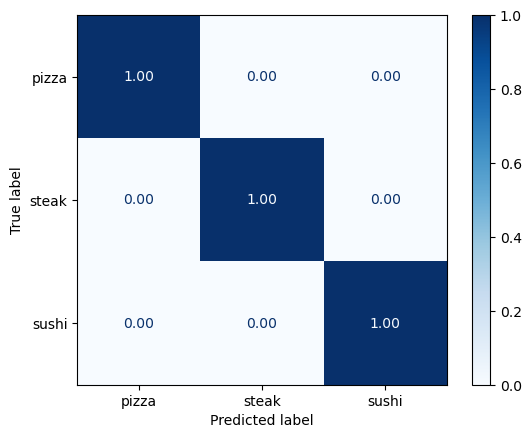

In [42]:
# ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
    true_labels, predicted_labels
    , normalize="true", cmap="Blues"
)

# replace default annotations with two-decimal strings
for txt in plt.gca().texts: txt.set_text(f"{float(txt.get_text()):.2f}")
plt.show();

In [43]:
import os
from PIL import Image
import torch
from torchvision import models
from matplotlib import pyplot as plt

In [44]:
# Updated predix function w/ probabilities displayed;

def show_image_prediction(img_path):
    # Load and preprocess
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess_eff(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        pred_idx = probabilities.argmax()
        pred_class = class_names[pred_idx]
        pred_prob = probabilities[pred_idx].item() * 100

    # Display image with prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} ({pred_prob:.2f}%)", fontsize=14, color='green')
    plt.show()

    # Print probability distribution below the image
    print("Class probabilities:")
    for i, cls in enumerate(class_names):
        prob = probabilities[i].item() * 100
        mark = "True" if i == pred_idx else "False"
        print(f"{mark} {cls:10s}: {prob:.4f}%")

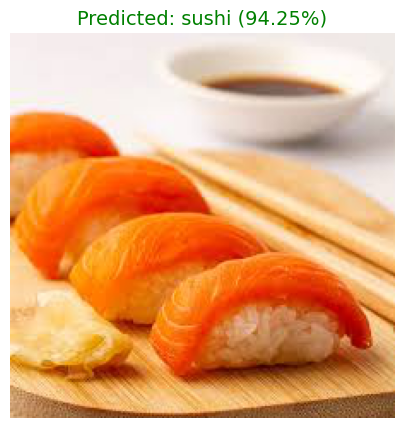

Class probabilities:
False pizza     : 3.3055%
False steak     : 2.4425%
True sushi     : 94.2521%


In [56]:
import random, os
# random.seed(27)   # change or remove for non-deterministic randomness
rand_image_path = os.path.join(folder_path, random.choice(image_files))
show_image_prediction(rand_image_path)

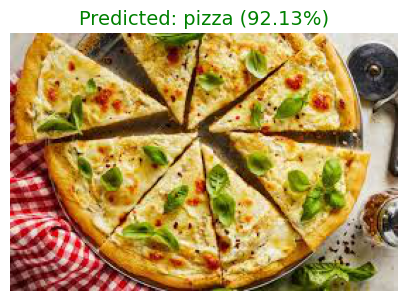

Class probabilities:
True pizza     : 92.1272%
False steak     : 3.9566%
False sushi     : 3.9162%


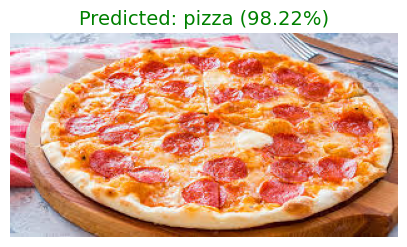

Class probabilities:
True pizza     : 98.2218%
False steak     : 0.9036%
False sushi     : 0.8746%


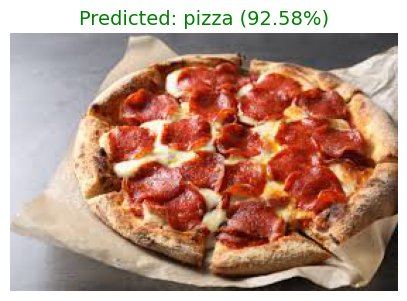

Class probabilities:
True pizza     : 92.5838%
False steak     : 3.7420%
False sushi     : 3.6742%


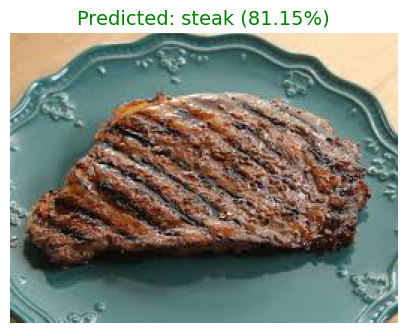

Class probabilities:
False pizza     : 12.5242%
True steak     : 81.1476%
False sushi     : 6.3282%


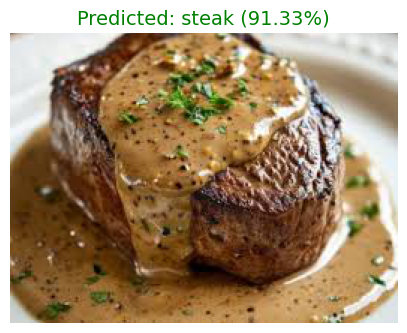

Class probabilities:
False pizza     : 6.4058%
True steak     : 91.3297%
False sushi     : 2.2645%


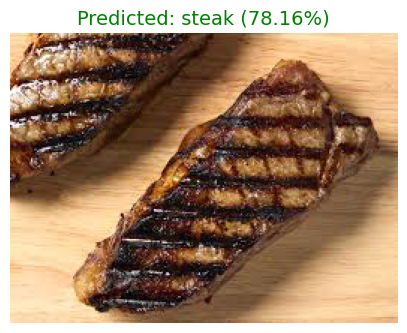

Class probabilities:
False pizza     : 12.8593%
True steak     : 78.1630%
False sushi     : 8.9777%


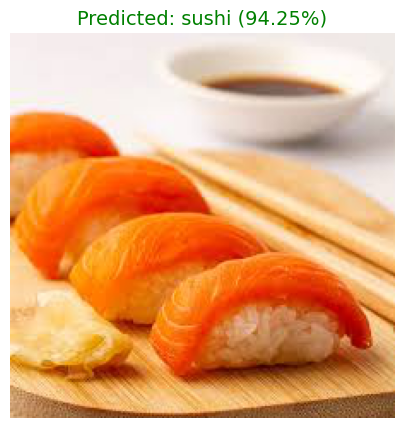

Class probabilities:
False pizza     : 3.3055%
False steak     : 2.4425%
True sushi     : 94.2521%


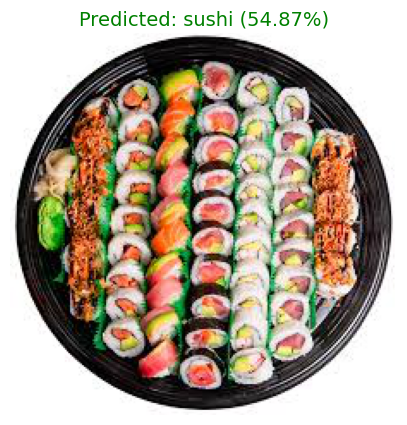

Class probabilities:
False pizza     : 32.5752%
False steak     : 12.5556%
True sushi     : 54.8692%


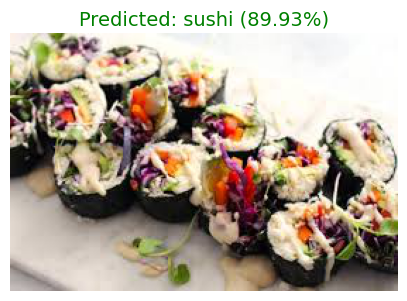

Class probabilities:
False pizza     : 8.3325%
False steak     : 1.7391%
True sushi     : 89.9284%


In [57]:
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    show_image_prediction(img_path)

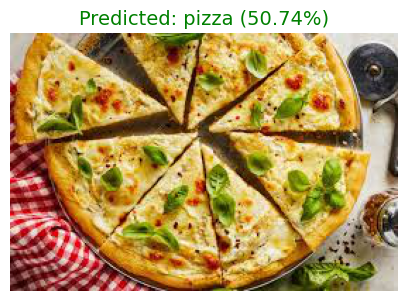

Class probabilities:
True pizza     : 50.7365%
False steak     : 17.2501%
False sushi     : 32.0134%


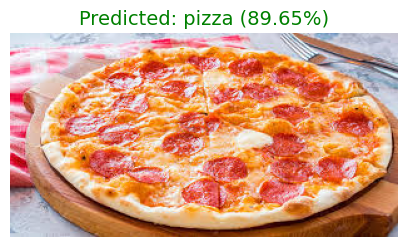

Class probabilities:
True pizza     : 89.6513%
False steak     : 4.8893%
False sushi     : 5.4594%


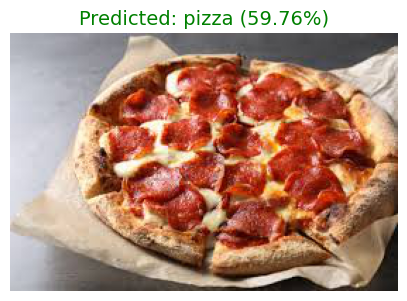

Class probabilities:
True pizza     : 59.7596%
False steak     : 18.2487%
False sushi     : 21.9917%


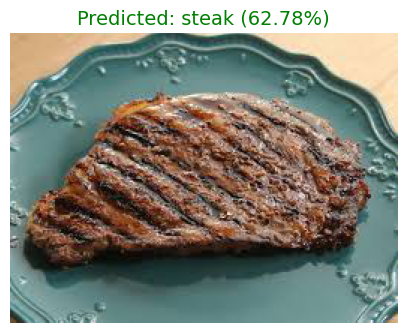

Class probabilities:
False pizza     : 18.9979%
True steak     : 62.7835%
False sushi     : 18.2186%


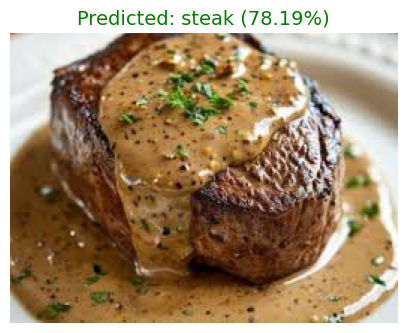

Class probabilities:
False pizza     : 12.9815%
True steak     : 78.1900%
False sushi     : 8.8285%


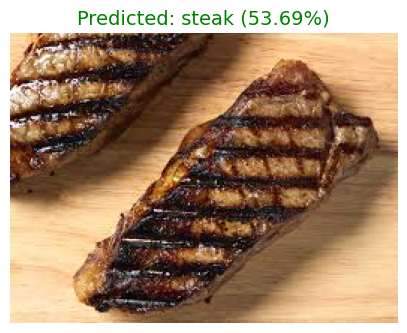

Class probabilities:
False pizza     : 22.7925%
True steak     : 53.6857%
False sushi     : 23.5218%


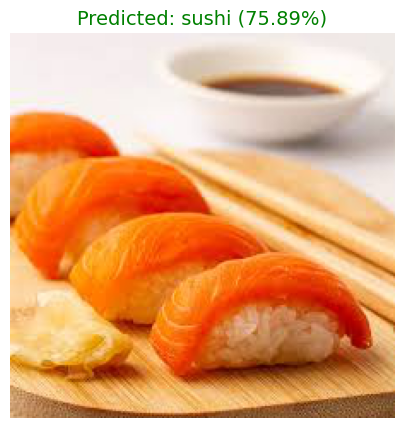

Class probabilities:
False pizza     : 9.0072%
False steak     : 15.1035%
True sushi     : 75.8893%


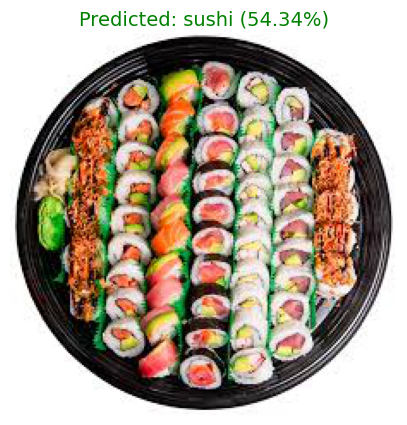

Class probabilities:
False pizza     : 24.1217%
False steak     : 21.5416%
True sushi     : 54.3367%


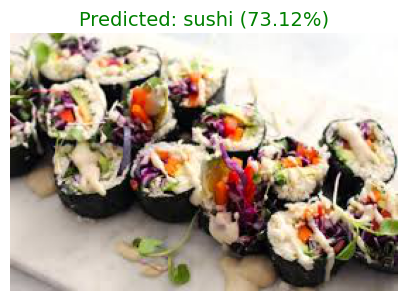

Class probabilities:
False pizza     : 15.1684%
False steak     : 11.7106%
True sushi     : 73.1210%


In [153]:
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    show_image_prediction(img_path)

In [154]:
# get one batch
images, labels = next(iter(train_loader))

print("images.shape:", images.shape)   # e.g. torch.Size([32, 3, H, W])
print("labels.shape:", labels.shape)   # e.g. torch.Size([32])

images.shape: torch.Size([32, 3, 288, 288])
labels.shape: torch.Size([32])


In [32]:
images, labels = next(iter(train_loader))
i = torch.randint(len(images), (1,)).item()   # random index in the batch
print(f"sample index: {i}")
print("single image shape:", images[i].shape)  # e.g. torch.Size([3, H, W])
print("single label:", labels[i].item())

sample index: 25
single image shape: torch.Size([3, 288, 288])
single label: 2


In [33]:
import random
idx = random.randrange(len(train_dataset))
img, label = train_dataset[idx]
print("dataset sample shape:", img.shape)   # e.g. torch.Size([3, H, W])
print("label:", label)

dataset sample shape: torch.Size([3, 288, 288])
label: 0


### Observations ###

**Experiment 1 (2025-10-22)**

- In comparing EfficientNetB2 vs EfficientNetB0 performance, the B2 was only fractionally better in test data - BUT - when looking at the probabilities in the labels, the B0 probabilities were much better on correct labeling (hence, it could be argued that B0 - all things being equal - was *more* correct.)

**Experiment 2 (2025-10-24)**

- I found some errors in my code which led to some incorrect img processing and discovered when I ran the unseen images, I had code in my eval loop which reverted the model back to pretrained weights (and base model!) Hence, all the training was for nought... 

- Additionally (and earlier in the experiment, came to realize that my scheduler was not even included in the train loop, so my learning rate annealing was not even happening! This has been fixed, and the "marginal improvement in test data" went up significantly --- (testing today resulted in 93.333% and 92.000% test acc, respectively --> which is a sizeable bump from the 88.000% from EfficientNetB0 and the previously erroneous 89.333% from our 2025-10-22 experiments with EfficientNetB2 (which was not lr adjusting!)

In [124]:
# model.classifier, 
# weights_eff = models.EfficientNet_B2_Weights.IMAGENET1K_V1
# model_eff = models.efficientnet_b2(weights=weights_eff)
# preprocess_eff = weights_eff.transforms()
# weights_eff.name, 
weights_eff
# preprocess_eff

EfficientNet_B2_Weights.IMAGENET1K_V1

In [125]:
# Convert to string safely
weights_str = str(weights_eff)  # e.g. 'EfficientNet_B2_Weights.IMAGENET1K_V1'

# Extract model name before '_Weights'
named_model = weights_str.split('_Weights')[0]

print(named_model)

EfficientNet_B2
